In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


# Any results you write to the current directory are saved as output.

In [3]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\DELL\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
df = pd.read_csv('fer2013.csv')
#check data shape
df.shape

(35887, 3)

In [5]:
df.head(20)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [6]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'depression', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,depression,6077
5,Surprise,4002
6,Neutral,6198


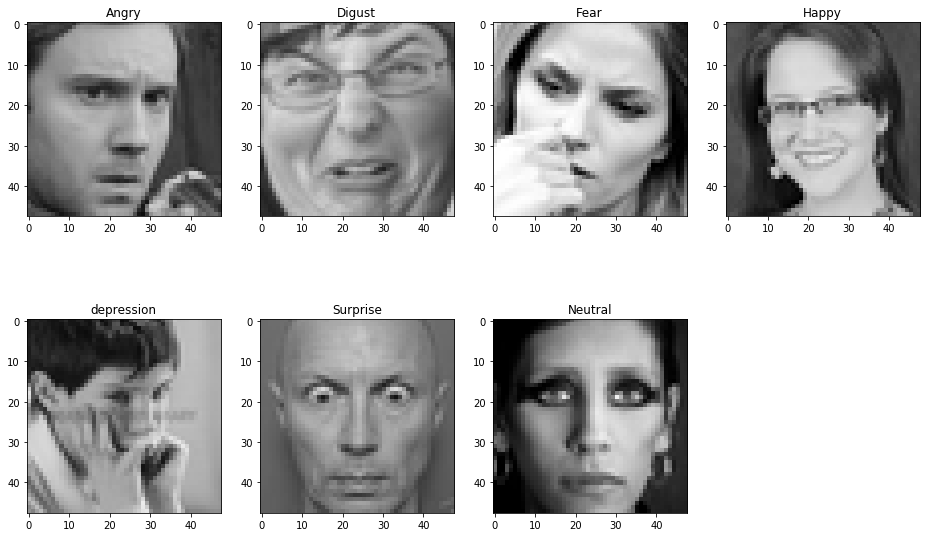

In [7]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = df[df['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

In [8]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y


In [9]:
X, Y = getData("fer2013.csv")
num_class = len(set(Y))
print(num_class)

7


In [10]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [13]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

In [14]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()
    
    return model
model=my_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)     

In [15]:
path_model='model_filter.h5' # save model at this location after each epoch
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=20, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )


Train on 32298 samples, validate on 3589 samples
Epoch 1/20
32298/32298 [==============================] - 882s 27ms/step - loss: 1.6545 - accuracy: 0.3559 - val_loss: 1.7533 - val_accuracy: 0.3639
Epoch 2/20
32298/32298 [==============================] - 847s 26ms/step - loss: 1.2793 - accuracy: 0.5124 - val_loss: 1.3172 - val_accuracy: 0.4907
Epoch 3/20
32298/32298 [==============================] - 846s 26ms/step - loss: 1.0999 - accuracy: 0.5848 - val_loss: 1.2453 - val_accuracy: 0.5038
Epoch 4/20
32298/32298 [==============================] - 843s 26ms/step - loss: 0.9779 - accuracy: 0.6332 - val_loss: 1.2350 - val_accuracy: 0.5297
Epoch 5/20
32298/32298 [==============================] - 843s 26ms/step - loss: 0.8638 - accuracy: 0.6795 - val_loss: 1.1670 - val_accuracy: 0.5617
Epoch 6/20
32298/32298 [==============================] - 845s 26ms/step - loss: 0.7259 - accuracy: 0.7332 - val_loss: 1.1512 - val_accuracy: 0.6046
Epoch 7/20
32298/32298 [==============================] 

In [14]:
objects = ('angry', 'disgust', 'fear', 'happy', 'depression', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [ ]:
# serialize weights to HDF5
#model.save_weights("model.h5")
#print("Saved model to disk")

In [1]:
from tensorflow.keras.models import Sequential, save_model, load_model
 
# load model
model = load_model('model_filter.h5',compile = True)
# summarize model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)      

In [15]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'depression', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [12]:
y_pred=model.predict(X_test)
#print(y_pred)
y_test.shape

NameError: name 'X_test' is not defined

In [ ]:
#import seaborn as sn
#import pandas as pd
#import matplotlib.pyplot as plt
#import numpy as np
#from sklearn.metrics import confusion_matrix
#%matplotlib inline
#cm = confusion_matrix(np.where(y_test == 1)[1], y_pred)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#df_cm = pd.DataFrame(cm, index = [i for i in "0123456"],
                  #columns = [i for i in "0123456"])
#plt.figure(figsize = (20,15))
#sn.heatmap(df_cm, annot=True)

**Real Time Expression Prediction**

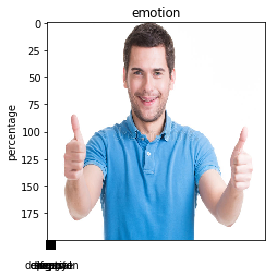

Expression Prediction: fear


In [18]:
from skimage import io
img = image.load_img('bahagia.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('bahagia.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

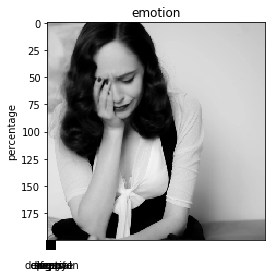

Expression Prediction: depression


In [19]:
from skimage import io
img = image.load_img('depresi.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('depresi.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

**Live Demo of Production Level Project**

[Facial Expression Detection Web App](https://faceai.herokuapp.com/)